In [1]:
#packages
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
from datetime import datetime
import sys
import warnings
from glob import glob
import netCDF4 as nc
import h5netcdf



In [16]:
# data
## ERA5
#era =  xr.open_dataset('../data/ERA_data_TC_Freddy.nc')

In [10]:
## Pangu in one dataset
#all_files=sorted(glob('../data/data_pangu/TC_FREDDY*'))
#pangu=xr.open_mfdataset(all_files)

<xarray.DataArray 'step' (step: 14)>
array([ 842400000000000,  864000000000000,  885600000000000,  907200000000000,
        928800000000000,  950400000000000,  972000000000000,  993600000000000,
       1015200000000000, 1036800000000000, 1058400000000000, 1080000000000000,
       1101600000000000, 1123200000000000], dtype='timedelta64[ns]')
Coordinates:
  * step               (step) timedelta64[ns] 9 days 18:00:00 ... 13 days 00:...
    valid_time         (step) datetime64[ns] dask.array<chunksize=(14,), meta=np.ndarray>
    time               datetime64[ns] ...
    meanSea            float64 ...
    heightAboveGround  float64 ...
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

In [14]:
file = '../data/data_new/data_pangu/TC_FREDDY2_20230223.nc'
pangu_x = xr.open_mfdataset(file)

In [15]:
pangu_x.valid_time

<xarray.DataArray 'valid_time' (step: 14)>
dask.array<open_dataset-valid_time, shape=(14,), dtype=datetime64[ns], chunksize=(14,), chunktype=numpy.ndarray>
Coordinates:
  * step               (step) timedelta64[ns] 0 days 06:00:00 ... 3 days 12:0...
    valid_time         (step) datetime64[ns] dask.array<chunksize=(14,), meta=np.ndarray>
    time               datetime64[ns] ...
    meanSea            float64 ...
    heightAboveGround  float64 ...
Attributes:
    standard_name:  time
    long_name:      time

In [ ]:
# calculate winds speed at 850/500hPa level
# for era
#era = era.assign(wind_speed = lambda era: (era.u**2 + era.v**2)**0.5)
#era['wind_speed'].attrs['GRIB_name'] = 'Wind speed'
# for pangu
#pangu = pangu.assign(wind_speed = lambda pangu: (pangu.u**2 + pangu.v**2)**0.5)
#pangu['wind_speed'].attrs['GRIB_name'] = 'Wind speed'

# calculate winds speed at SURFACE level
# for era
#era = era.assign(wind_speed_sfc = lambda era: (era.u10**2 + era.v10**2)**0.5)
#era['wind_speed_sfc'].attrs['GRIB_name'] = 'Surface wind speed'
# for pangu
#pangu = pangu.assign(wind_speed_sfc = lambda pangu: (pangu.u10**2 + pangu.v10**2)**0.5)
#pangu['wind_speed_sfc'].attrs['GRIB_name'] = 'Surface wind speed'

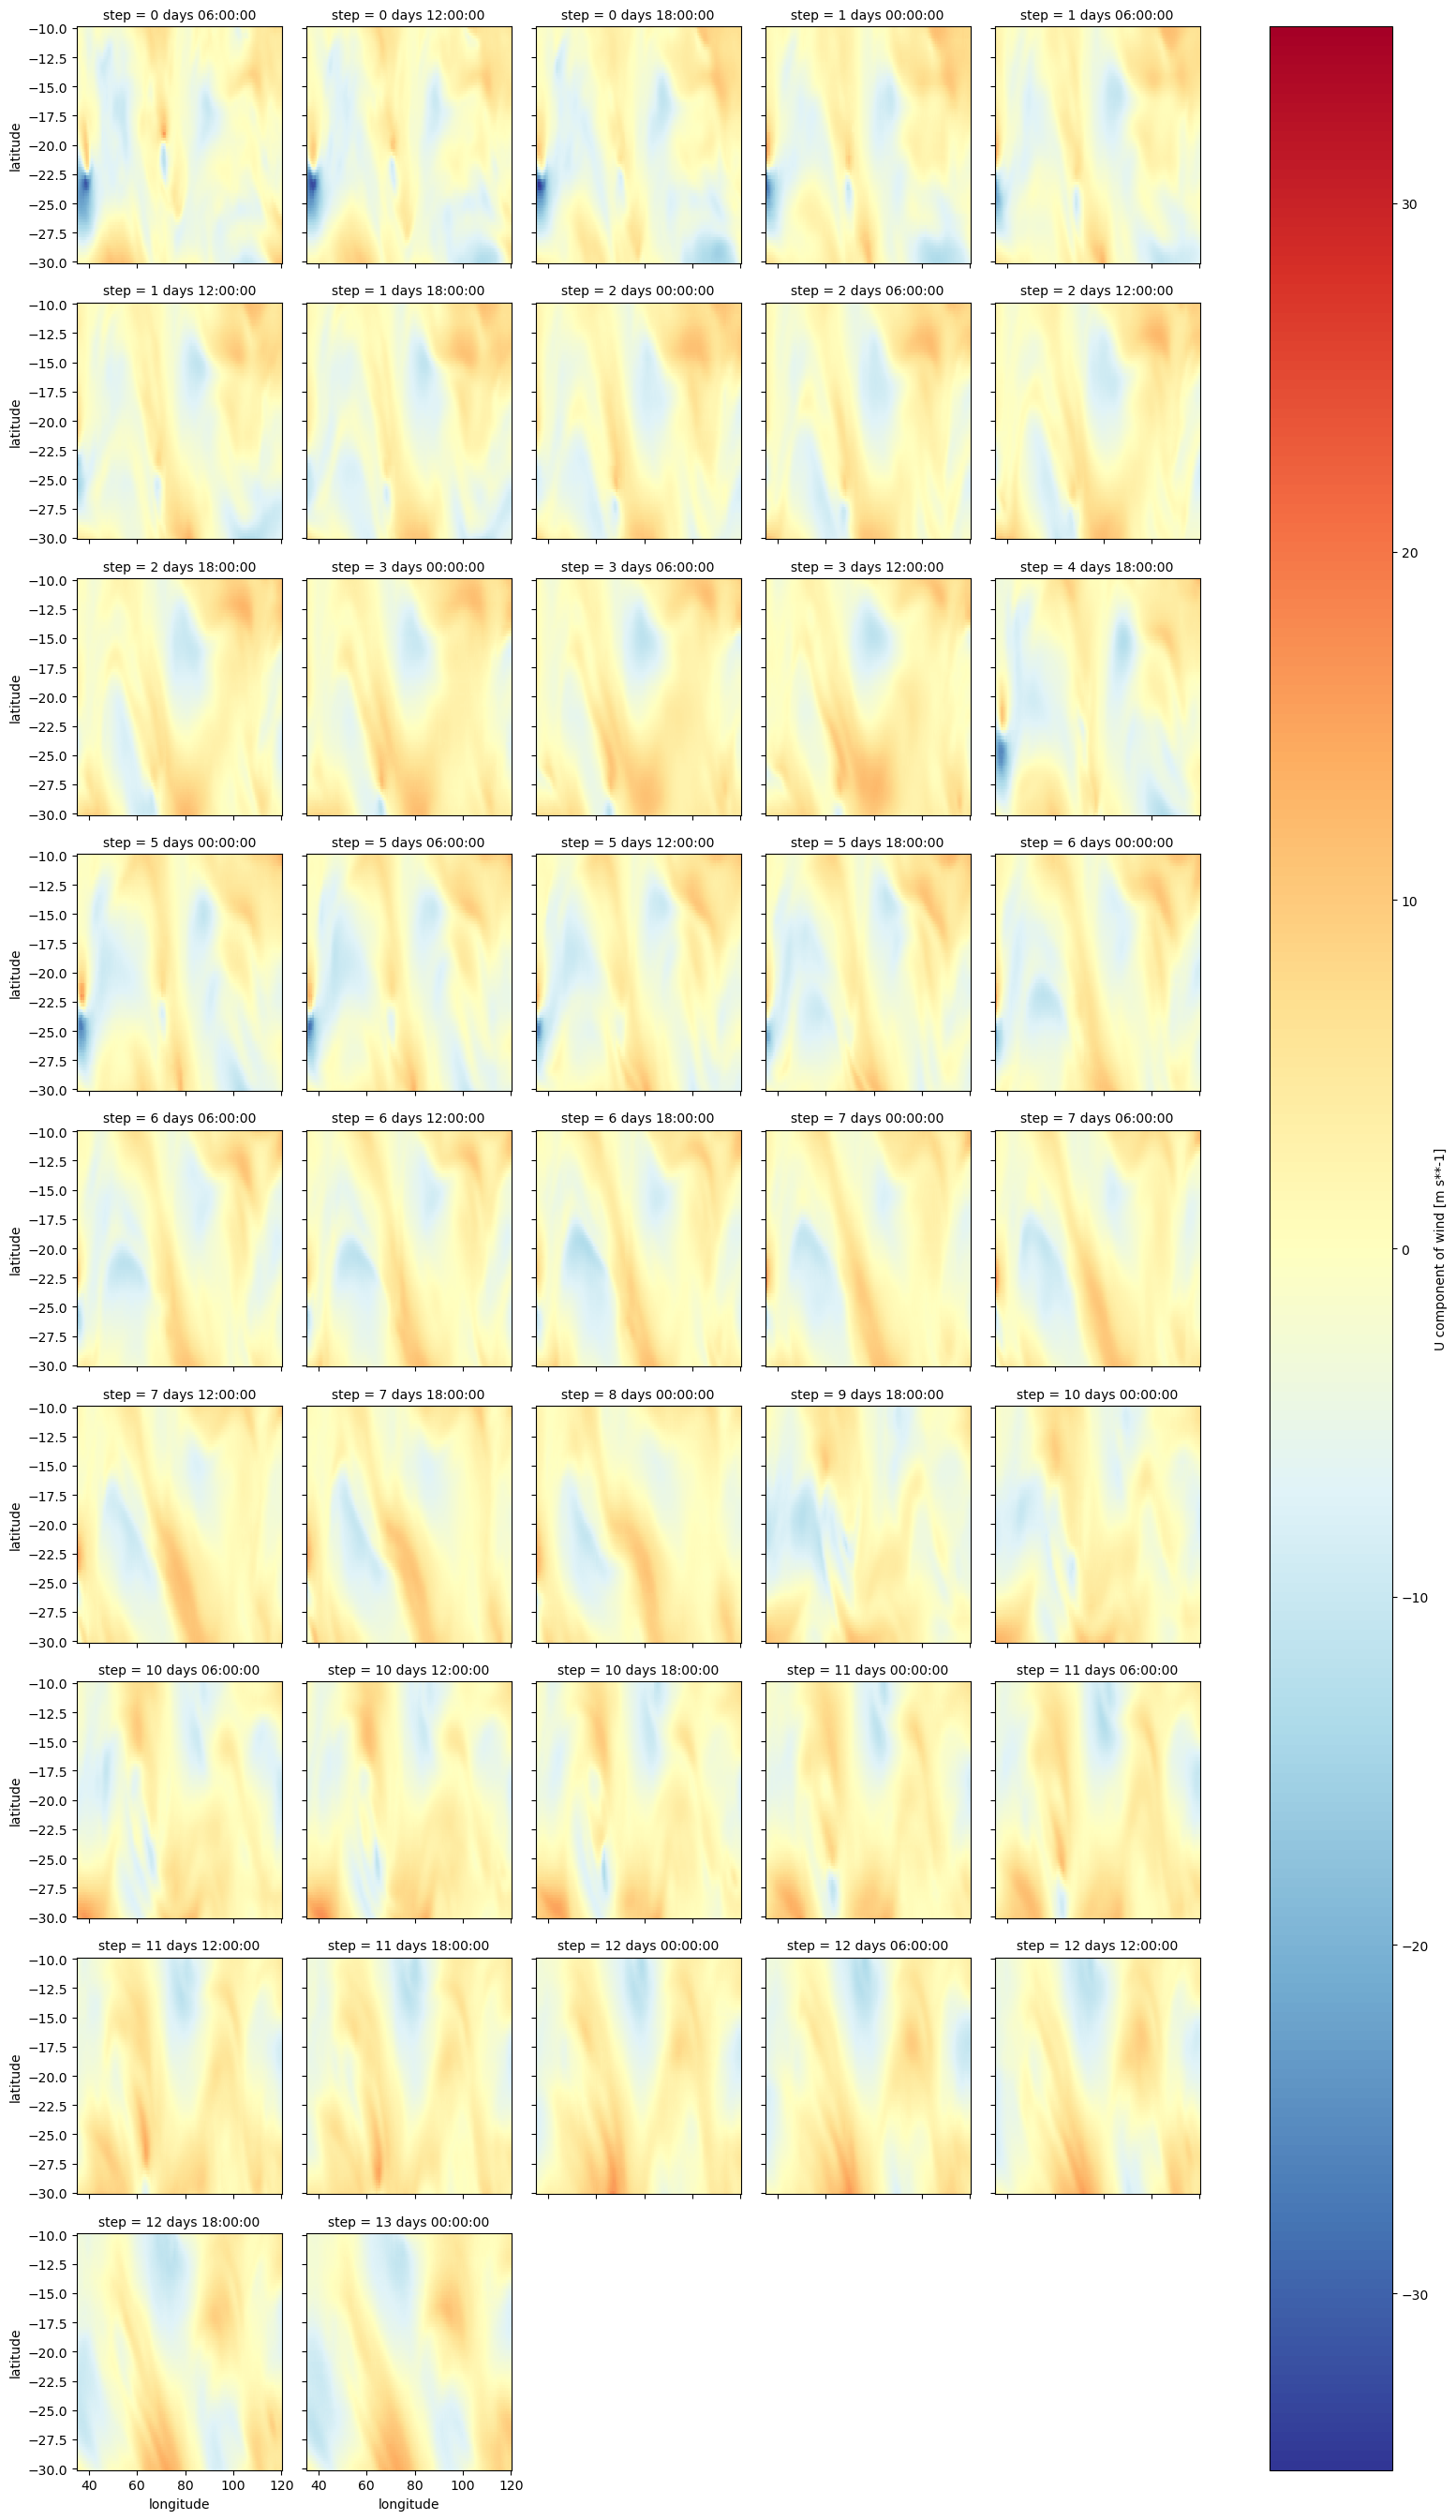

In [52]:
#pangu.u.sel(isobaricInhPa=500).plot( col='step', col_wrap=5,cmap='RdYlBu_r')

values for the function pangu contourf contour:
- value for contourf
- value for contour
- step (you need to know which step corresponds to which time and init, Datenreihenfolge 23.02,19.02,14.02)
- isobaricInhPa value (500/850)
- legend levels for contourf
- legend levels for contour
- variable_cmap (colors) for legend
- label for legend

In [ ]:
# function: Differences for contourf (with isobaricInhPa dependency) + contour (without isobaricInhPa dependency)
             

def diff_contourfPA_contour(data, #the whole dataset
                             contourf_var, #base variable
                             contour_var,  #overlaying variable !only surface processes
                            init_pangu,    #initialisation of pangu as a string like "2023-02-23T12"
                             pressure,     #pressure lvl (500 == 1/850 == 0)
                             contourf_lvl, #base variable range 
                             contour_lvl,  #overlaying variable range
                             legend_colormap, #color scheme as a map
                            legend_title,    #variable name for legend
                            contour_var_name #name of the second variable for plot text
                            ):
    
#    # extract time of observation and time of initialization
    valid_time = data.valid_time   #extract
    valid_time = np.datetime_as_string(valid_time,unit='h')              #convert
    init_time = init_pangu
    
    # Create a figure instance
    fig = plt.figure(figsize=(9,5))
    
    # Define map projections
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Specify the tick labels
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right side
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    # bounds for color bar
    maxi = contourf_lvl.max()
    mini = contourf_lvl.min()
    
    # Plot contour
    contourf_var.sel(isobaricInhPa = contourf_var.isobaricInhPa[pressure]).squeeze().plot.contourf(ax=ax, 
                                                                              transform=map_projection, 
                                                                              levels=contourf_lvl, # sets discrete ranges
                                                                              vmin=mini, 
                                                                              vmax=maxi, # sets bounds of the colour bar,
                                                                              cmap=legend_colormap,
                                                                              cbar_kwargs=dict( # colour bar params
                                                                                  label=str(legend_title), shrink=0.8))
    
    # Plotting contour lines for mean sea level pressure (MSL) with labels
    contour = contour_var.sel().squeeze().plot.contour(levels=contour_lvl,
                                                                                cmap='black', 
                                                                                linestyles='--')
  
    # Adding contour labels
    contour_labels = plt.clabel(contour, inline=True, fontsize=12, fmt='%1.0f')

    # Customize appearance of all labels at once
    plt.setp(contour_labels, color='black')
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='-')
    
    ax.set_title('') # to supress xarray auto-title
    
    # title variable description
    ax.set_title('ERA5 - Pangu  // ' + str(legend_title)+ " at " + str(data['isobaricInhPa'].values[pressure]) +"hPa, " + 
                     str(contour_var_name) + " contours", loc='left');

    plt.text(1, -0.15, 'Init. of Pangu: {}'.format(init_time), fontsize=12, ha='right', va='bottom', transform=ax.transAxes)
    plt.text(0, -0.15, 'Valid time:{}'.format(valid_time), fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
    
    
    # save file in folder: plots    
    plt.savefig("../plots/pangu_"+ init_time + legend_title + str(data['isobaricInhPa'].values[pressure]) +"_"+ 
                str(contour_var_name)+ ".png", dpi=300, bbox_inches='tight')
    
    plt.show()



In [1]:
# function: Pangu for contourf (with isobaricInhPa dependency) + contour (without isobaricInhPa dependency)
             

def pangu_contourfPA_contour(data, #the whole dataset
                             contourf_var, #base variable
                             contour_var,  #overlaying variable !only surface processes
                             ttime,        #index which pangu dataset to use
                             step_time,    #step for this plot
                             pressure,     #pressure lvl (500/850)
                             contourf_lvl, #base variable range 
                             contour_lvl,  #overlaying variable range
                             legend_colormap, #color scheme as a map
                            ):
    
#    # extract time of observation and time of initialization
    valid_time = data.valid_time.sel(step=data.step[step_time],
                                      time=data.time[ttime]).values   #extract
    valid_time = np.datetime_as_string(valid_time,unit='h')              #convert
    init_time = data.time.sel(time = data.time[ttime]).values 
    init_time = np.datetime_as_string(init_time,unit='h')
    
    # Create a figure instance
    fig = plt.figure(figsize=(9,5))
    
    # Define map projections
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Specify the tick labels
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right side
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    # bounds for color bar
    maxi = contourf_lvl.max()
    mini = contourf_lvl.min()
    
    # Plot contour
    contourf_var.sel(time = contourf_var.time[ttime],
                     step = contourf_var.step[step_time], 
                     isobaricInhPa = contourf_var.isobaricInhPa[pressure]).squeeze().plot.contourf(ax=ax, 
                                                                              transform=map_projection, 
                                                                              levels=contourf_lvl, # sets discrete ranges
                                                                              vmin=mini, 
                                                                              vmax=maxi, # sets bounds of the colour bar,
                                                                              cmap=legend_colormap,
                                                                              cbar_kwargs=dict( # colour bar params
                                                                                  label=str(contourf_var.GRIB_name), shrink=0.8))
    
    # Plotting contour lines for mean sea level pressure (MSL) with labels
    contour = contour_var.sel(step = contour_var.step[step_time],
                              time = contour_var.time[ttime]).squeeze().plot.contour(levels=contour_lvl,
                                                                                cmap='black', 
                                                                                linestyles='--')
  
    # Adding contour labels
    contour_labels = plt.clabel(contour, inline=True, fontsize=12, fmt='%1.0f')

    # Customize appearance of all labels at once
    plt.setp(contour_labels, color='black')
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='-')
    
    ax.set_title('') # to supress xarray auto-title
    
    # title variable description
    ax.set_title('Pangu // ' + str(contourf_var.GRIB_name)+ " at " + str(data['isobaricInhPa'].values[pressure]) +"hPa, " + 
                     str(contour_var.GRIB_name) + " contours", loc='left');

    plt.text(1, -0.15, 'Init.: {}'.format(init_time), fontsize=12, ha='right', va='bottom', transform=ax.transAxes)
    plt.text(0, -0.15, 'Valid time:{}'.format(valid_time), fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
        
    # save file in folder: plots    
    plt.savefig("../plots/pangu_"+ init_time + contourf_var.GRIB_name + str(data['isobaricInhPa'].values[pressure]) +"_"+ 
                str(contour_var.GRIB_name)+ ".png", dpi=300, bbox_inches='tight')
    
    plt.show()



In [ ]:
# function: Pangu for contourf (with isobaricInhPa dependency) + contour (without isobaricInhPa dependency)
             

def pangu_contourf_contourPA_test(data, #the whole dataset
                             contourf_var, #base variable
                             contour_var,  #overlaying variable !only surface processes
                             ttime,        #index which pangu dataset to use
                             step_time,    #step for this plot
                             pressure,     #pressure lvl (500/850)
                             contourf_lvl, #base variable range 
                             contour_lvl,  #overlaying variable range
                             legend_colormap, #color scheme as a map
                            ):
    
#    # extract time of observation and time of initialization
    valid_time = data.valid_time.sel(step=data.step[step_time],
                                      time=data.time[ttime]).values   #extract
    valid_time = np.datetime_as_string(valid_time,unit='h')              #convert
    init_time = data.time.sel(time = data.time[ttime]).values 
    init_time = np.datetime_as_string(init_time,unit='h')
    
    # Create a figure instance
    fig = plt.figure(figsize=(9,5))
    
    # Define map projections
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Specify the tick labels
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right side
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    # bounds for color bar
    maxi = contourf_lvl.max()
    mini = contourf_lvl.min()
    
    # Plot contour
    contourf_var.sel(time = contourf_var.time[ttime],
                     step = contourf_var.step[step_time]).squeeze().plot.contourf(ax=ax, 
                                                                              transform=map_projection, 
                                                                              levels=contourf_lvl, # sets discrete ranges
                                                                              vmin=mini, 
                                                                              vmax=maxi, # sets bounds of the colour bar,
                                                                              cmap=legend_colormap,
                                                                              cbar_kwargs=dict( # colour bar params
                                                                                  label=str(contourf_var.GRIB_name), shrink=0.8))
    
    # Plotting contour lines for mean sea level pressure (MSL) with labels
    contour = contour_var.sel(step = contour_var.step[step_time],
                              time = contour_var.time[ttime],
                              isobaricInhPa = contour_var.isobaricInhPa[pressure]).squeeze().plot.contour(levels=contour_lvl,
                                                                                cmap='black', 
                                                                                linestyles='--')
  
    # Adding contour labels
    contour_labels = plt.clabel(contour, inline=True, fontsize=12, fmt='%1.0f')

    # Customize appearance of all labels at once
    plt.setp(contour_labels, color='black')
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='-')
    
    ax.set_title('') # to supress xarray auto-title
    
    # title variable description
    ax.set_title('Pangu // ' + str(contourf_var.GRIB_name)+", " + 
                     str(contour_var.GRIB_name) + " at " + str(data['isobaricInhPa'].values[pressure]) + "(hPa) contours", loc='left');

    plt.text(1, -0.15, 'Init.: {}'.format(init_time), fontsize=12, ha='right', va='bottom', transform=ax.transAxes)
    plt.text(0, -0.15, 'Valid time:{}'.format(valid_time), fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
        
    # save file in folder: plots    
    plt.savefig("../plots/pangu_"+ init_time + contourf_var.GRIB_name + "_"+ 
                str(contour_var.GRIB_name)+str(data['isobaricInhPa'].values[pressure]) + ".png", dpi=300, bbox_inches='tight')
    
    plt.show()



In [5]:
# old function before new data
# function: Pangu for contourf (with isobaricInhPa dependency) + contour (with isobaricInhPa dependency)
#              
# 
# def pangu_contourfPA_contourPA(data, #the whole dataset
#                                contourf_var, #base variable
#                                contour_var,  #overlaying variable !only surface processes
#                                step_time,    #step for this plot
#                                pressure,     #pressure lvl (500/850)
#                                contourf_lvl, #base variable range 
#                                contour_lvl,  #overlaying variable range
#                                legend_colormap, #color scheme as a map
#                               ):
#     
#     # extract time of observation and time of initialization
#     valid_time = data.valid_time.sel(step=data.step[step_time]).values   #extract
#     valid_time = np.datetime_as_string(valid_time,unit='h')              #convert
#     init_time = data.time.sel(step=data.step[step_time]).values 
#     init_time = np.datetime_as_string(init_time,unit='h')
#     
#     # Create a figure instance
#     fig = plt.figure(figsize=(14,6))
#     
#     # Define map projections
#     map_projection = ccrs.PlateCarree()
#     ax = plt.axes(projection=map_projection)
#     
#     # Gridlines
#     gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
# 
#     # Specify the tick labels
#     gl.top_labels = False  # Disable labels on top
#     gl.right_labels = False  # Disable labels on right side
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
#     
#     
#     # bounds for color bar
#     maxi = contourf_lvl.max()
#     mini = contourf_lvl.min()
#     
#     # Plot contour
#     contourf_var.sel(step=data.step[step_time], isobaricInhPa=pressure).squeeze().plot.contourf(ax=ax, 
#                                                                               transform=map_projection, 
#                                                                               levels=contourf_lvl, # sets discrete ranges
#                                                                               vmin=mini, 
#                                                                               vmax=maxi, # sets bounds of the colour bar,
#                                                                               cmap=legend_colormap,
#                                                                               cbar_kwargs=dict( # colour bar params
#                                                                                   label=str(contourf_var.GRIB_name), shrink=0.8))
#     
#     # Plotting contour lines for mean sea level pressure (MSL) with labels
#     contour = contour_var.sel(step=data.step[step_time], isobaricInhPa=pressure).squeeze().plot.contour(levels=contour_lvl,
#                                                                                 cmap='dimgray', 
#                                                                                 linestyles='dotted')
#     # Adding contour labels
#     plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
#     
#     # Add coastlines
#     ax.add_feature(cfeature.COASTLINE, linestyle='-')
#     
#     ax.set_title('') # to supress xarray auto-title
#     ax.set_title('Valid time:{}'.format(valid_time), loc='right');
#     
#     # title variable description
#     ax.set_title('Pangu // ' + str(contourf_var.GRIB_name)+ " at " + str(pressure) +"hPa, " + 
#                      str(contour_var.GRIB_name) + " contours", loc='left');
# 
# 
#     plt.text(1, -0.1, 'Init.: {}'.format(init_time), fontsize=12, ha='right', va='bottom', transform=ax.transAxes)
#     
#     # save file in folder: plots    
#     plt.savefig("../plots/pangu_"+ init_time + contourf_var.GRIB_name + str(pressure) +"_"+ 
#                 str(contour_var.GRIB_name)+ ".png", dpi=300, bbox_inches='tight')
#     
#     plt.show()
# 
# 

In [4]:
# no need for this function: not scientific
# function: Pangu for contourf (with isobaricInhPa dependency) + contour wind vectors (without isobaricInhPa dependency)
#              
# 
# def pangu_contourfPA_contour_wind(data, #the whole dataset
#                                   contourf_var, #base variable
#                                   contour_var,  #overlaying variable !only surface processes
#                                   step_time,    #step for this plot
#                                   pressure,     #pressure lvl (500/850)
#                                   contourf_lvl, #base variable range 
#                                   contour_lvl,  #overlaying variable range
#                                   legend_colormap, #color scheme as a map
#                                  ):
#     
#     # extract time of observation and time of initialization
#     valid_time = data.valid_time.sel(step=data.step[step_time]).values   #extract
#     valid_time = np.datetime_as_string(valid_time,unit='h')              #convert
#     init_time = data.time.sel(step=data.step[step_time]).values 
#     init_time = np.datetime_as_string(init_time,unit='h')
#     
#     # Create a figure instance
#     fig = plt.figure(figsize=(14,6))
#     
#     # Define map projections
#     map_projection = ccrs.PlateCarree()
#     ax = plt.axes(projection=map_projection)
#     
#     # Gridlines
#     gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
# 
#     # Specify the tick labels
#     gl.top_labels = False  # Disable labels on top
#     gl.right_labels = False  # Disable labels on right side
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
#     
#     
#     # bounds for color bar
#     maxi = contourf_lvl.max()
#     mini = contourf_lvl.min()
#     
#     # Plot contour
#     contourf_var.sel(step=data.step[step_time], isobaricInhPa=pressure).squeeze().plot.contourf(ax=ax, 
#                                                                               transform=map_projection, 
#                                                                               levels=contourf_lvl, # sets discrete ranges
#                                                                               vmin=mini, 
#                                                                               vmax=maxi, # sets bounds of the colour bar,
#                                                                               cmap=legend_colormap,
#                                                                               cbar_kwargs=dict( # colour bar params
#                                                                                   label=str(contourf_var.GRIB_name), shrink=0.8))
#     
#     # Wind arrows for surface winds
#     subsample = data.sel(step=data.step[4]).isel(longitude=slice(None, None, 7), latitude=slice(None, None, 7))
#     subsample.squeeze().plot.quiver(x='longitude', y='latitude', u='u10', v='v10',scale=300)
#     
# 
#     
#     # Add coastlines
#     ax.add_feature(cfeature.COASTLINE, linestyle='-')
#     
#     ax.set_title('') # to supress xarray auto-title
#     ax.set_title('Valid time:{}'.format(valid_time), loc='right');
#     
#     # title variable description
#     ax.set_title('Pangu // ' + str(contourf_var.GRIB_name)+ " at " + str(pressure) +"hPa, " + 
#                      str(contour_var.GRIB_name) + " contours", loc='left');
#     plt.text(1, -0.1, 'Init.: {}'.format(init_time), fontsize=12, ha='right', va='bottom', transform=ax.transAxes)
#     
#     # save file in folder: plots    
#     plt.savefig("../plots/pangu_"+ init_time + contourf_var.GRIB_name + str(pressure) +"_"+ 
#                 str(contour_var.GRIB_name)+ ".png", dpi=300, bbox_inches='tight')
#     
#     plt.show()
# 
# 

In [12]:
# function: Pangu for contourf (without isobaricInhPa dependency) + contour (without isobaricInhPa dependency)
             

def pangu_contourf_contour(data, #the whole dataset
                             contourf_var, #base variable
                             contour_var,  #overlaying variable !only surface processes,
                           ttime, # selects the pangu observation
                             step_time,    #step for this plot
                             contourf_lvl, #base variable range 
                             contour_lvl,  #overlaying variable range
                             legend_colormap, #color scheme as a map
                            ):
    
    # extract time of observation and time of initialization
    valid_time = data.valid_time.sel(step=data.step[step_time]).values   #extract
    valid_time = np.datetime_as_string(valid_time,unit='h')              #convert
    init_time = data.time.sel(step=data.step[step_time]).values 
    init_time = np.datetime_as_string(init_time,unit='h')
    
    # Create a figure instance
    fig = plt.figure(figsize=(14,6))
    
    # Define map projections
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Specify the tick labels
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right side
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    # bounds for color bar
    maxi = contourf_lvl.max()
    mini = contourf_lvl.min()
    
    # Plot contour
    contourf_var.sel(step=data.step[step_time]).squeeze().plot.contourf(ax=ax, 
                                                                              transform=map_projection, 
                                                                              levels=contourf_lvl, # sets discrete ranges
                                                                              vmin=mini, 
                                                                              vmax=maxi, # sets bounds of the colour bar,
                                                                              cmap=legend_colormap,
                                                                              cbar_kwargs=dict( # colour bar params
                                                                                  label=str(contourf_var.GRIB_name), shrink=0.8))
    
    # Plotting contour lines for mean sea level pressure (MSL) with labels
    contour = contour_var.sel(step=data.step[step_time]).squeeze().plot.contour(levels=contour_lvl,
                                                                                cmap='dimgray', 
                                                                                linestyles='dotted')
    # Adding contour labels
    plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='-')
    
    ax.set_title('') # to supress xarray auto-title
    ax.set_title('Valid time:{}'.format(valid_time), loc='right');
    
    # title variable description
    ax.set_title('Pangu // ' + str(contourf_var.GRIB_name)+ ", "  + 
                     str(contour_var.GRIB_name) + " contours", loc='left');

    plt.text(1, -0.15, 'Init.: {}'.format(init_time), fontsize=12, ha='right', va='bottom', transform=ax.transAxes)
    
    # save file in folder: plots    
    plt.savefig("../plots/pangu_"+ init_time + contourf_var.GRIB_name +"_"+ 
                str(contour_var.GRIB_name)+ ".png", dpi=300, bbox_inches='tight')
    
    plt.show()



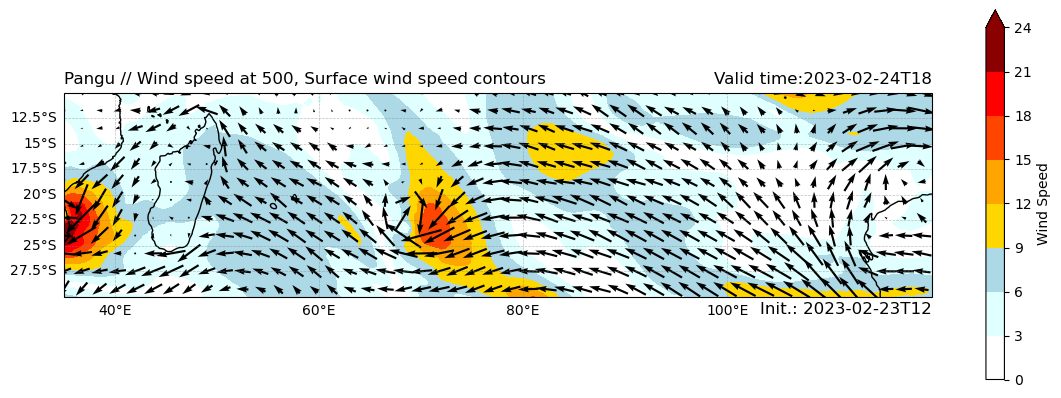

In [152]:
#pangu_contourfPA_contour_wind(data = pangu,
#                              contourf_var = pangu.wind_speed,
#                              contour_var = pangu.wind_speed_sfc,
#                              step_time = 4,
#                              pressure = 500,
#                              contourf_lvl = u_levels,
#                              contour_lvl = u_levels,
#                              legend_colormap = wind_speed_cmap,
#                              legend_label = 'Wind Speed')

In [ ]:
# function: ERA for contourf (with isobaricInhPa dependency) + contour (without isobaricInhPa dependency)
             

def era_contourfPA_contour(data, #the whole dataset
                           contourf_var, #base variable
                           contourf_var_inwords, #for plot title
                           contour_var,  #overlaying variable !only surface processes
                           contour_var_inwords, #for plot title
                           step_time,    #specific for this plot
                           pressure,     #pressure lvl (500/850)
                           contourf_lvl, #base variable range 
                           contour_lvl,  #overlaying variable range
                           legend_colormap, #color scheme as a map
                          ):
    
    # extract time of observation
    valid_time = step_time[:13]
    
    # Create a figure instance
    fig = plt.figure(figsize=(9,5))
    
    # Define map projections
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Specify the tick labels
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right side
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    # bounds for color bar
    maxi = contourf_lvl.max()
    mini = contourf_lvl.min()
    
    # Plot contour
    contourf_var.sel(time=step_time, level=pressure).squeeze().plot.contourf(ax=ax, 
                                                                              transform=map_projection, 
                                                                              levels=contourf_lvl, # sets discrete ranges
                                                                              vmin=mini, 
                                                                              vmax=maxi, # sets bounds of the colour bar,
                                                                              cmap=legend_colormap,
                                                                              cbar_kwargs=dict( # colour bar params
                                                                                  label=contourf_var_inwords, shrink=0.8))
    
    
        
    # Plotting contour lines
    contour = contour_var.sel(time=step_time).squeeze().plot.contour(levels=contour_lvl,
                                                                                cmap='black', 
                                                                                linestyles='--')
    # Adding contour labels
    plt.clabel(contour, inline=True, fontsize=12, fmt='%1.0f')
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='-')
    
    ax.set_title('') # to supress xarray auto-title
    
    # title variable description
    ax.set_title('ERA // ' + str(contourf_var_inwords)+ " at " + str(pressure) +"hPa, " + 
                     str(contour_var_inwords) + " contours", loc='left');
    plt.text(0, -0.15, 'Valid time:{}'.format(valid_time), fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
    
    # save file in folder: plots    
    plt.savefig("../plots/ERA"+ valid_time + contourf_var_inwords + str(pressure) +"_"+ 
                contour_var_inwords + ".png", dpi=300, bbox_inches='tight')
    
    plt.show()



In [ ]:
# function: ERA for contourf (with isobaricInhPa dependency) + contour (without isobaricInhPa dependency)
             

def era_contourf_contourPA_test(data, #the whole dataset
                           contourf_var, #base variable
                           contourf_var_inwords, #for plot title
                           contour_var,  #overlaying variable !only surface processes
                           contour_var_inwords, #for plot title
                           step_time,    #specific for this plot
                           pressure,     #pressure lvl (500/850)
                           contourf_lvl, #base variable range 
                           contour_lvl,  #overlaying variable range
                           legend_colormap, #color scheme as a map
                          ):
    
    # extract time of observation
    valid_time = step_time[:13]
    
    # Create a figure instance
    fig = plt.figure(figsize=(9,5))
    
    # Define map projections
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Specify the tick labels
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right side
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    # bounds for color bar
    maxi = contourf_lvl.max()
    mini = contourf_lvl.min()
    
    # Plot contour
    contourf_var.sel(time=step_time).squeeze().plot.contourf(ax=ax, 
                                                                              transform=map_projection, 
                                                                              levels=contourf_lvl, # sets discrete ranges
                                                                              vmin=mini, 
                                                                              vmax=maxi, # sets bounds of the colour bar,
                                                                              cmap=legend_colormap,
                                                                              cbar_kwargs=dict( # colour bar params
                                                                                  label=contourf_var_inwords, shrink=0.8))
    
    
        
    # Plotting contour lines
    contour = contour_var.sel(time=step_time, level=pressure).squeeze().plot.contour(levels=contour_lvl,
                                                                                cmap='black', 
                                                                                linestyles='--')
    # Adding contour labels
    plt.clabel(contour, inline=True, fontsize=12, fmt='%1.0f')
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='-')
    
    ax.set_title('') # to supress xarray auto-title
    
    # title variable description
    ax.set_title('ERA // ' + str(contourf_var_inwords)+  
                     str(contour_var_inwords) + " contours", loc='left');
    plt.text(0, -0.15, 'Valid time:{}'.format(valid_time), fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
    
    # save file in folder: plots    
    plt.savefig("../plots/ERA"+ valid_time + contourf_var_inwords + "_"+ 
                contour_var_inwords + ".png", dpi=300, bbox_inches='tight')
    
    plt.show()



In [7]:
# function: ERA for contourf (with isobaricInhPa dependency) + contour (without isobaricInhPa dependency)
#             
#
#def era_contourfPA_contour(data, #the whole dataset
#                           contourf_var, #base variable
#                           contourf_var_inwords, #for plot title
#                           contour_var,  #overlaying variable !only surface processes
#                           contour_var_inwords, #for plot title
#                           step_time,    #specific for this plot
#                           pressure,     #pressure lvl (500/850)
#                           contourf_lvl, #base variable range 
#                           contour_lvl,  #overlaying variable range
#                           legend_colormap, #color scheme as a map
#                          ):
#    
#    # extract time of observation
#    valid_time = step_time[:13]
#    
#    # Create a figure instance
#    fig = plt.figure(figsize=(14,6))
#    
#    # Define map projections
#    map_projection = ccrs.PlateCarree()
#    ax = plt.axes(projection=map_projection)
#    
#    # Gridlines
#    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#
#    # Specify the tick labels
#    gl.top_labels = False  # Disable labels on top
#    gl.right_labels = False  # Disable labels on right side
#    gl.xformatter = LONGITUDE_FORMATTER
#    gl.yformatter = LATITUDE_FORMATTER
#    
#    
#    # bounds for color bar
#    maxi = contourf_lvl.max()
#    mini = contourf_lvl.min()
#    
#    # Plot contour
#    contourf_var.sel(time=step_time, level=pressure).squeeze().plot.contourf(ax=ax, 
#                                                                              transform=map_projection, 
#                                                                              levels=contourf_lvl, # sets discrete ranges
#                                                                              vmin=mini, 
#                                                                              vmax=maxi, # sets bounds of the colour bar,
#                                                                              cmap=legend_colormap,
#                                                                              cbar_kwargs=dict( # colour bar params
#                                                                                  label=contourf_var_inwords, shrink=0.8))
#    
#    
#        
#    # Plotting contour lines
#    contour = contour_var.sel(time=step_time).squeeze().plot.contour(levels=contour_lvl,
#                                                                                cmap='dimgray', 
#                                                                                linestyles='dotted')
#    # Adding contour labels
#    plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
#    
#    # Add coastlines
#    ax.add_feature(cfeature.COASTLINE, linestyle='-')
#    
#    ax.set_title('') # to supress xarray auto-title
#    ax.set_title('Valid time:{}'.format(valid_time), loc='right');
#    
#    # title variable description
#    ax.set_title('ERA // ' + str(contourf_var_inwords)+ " at " + str(pressure) +"hPa, " + 
#                     str(contour_var_inwords) + " contours", loc='left');
#    
#    # save file in folder: plots    
#    plt.savefig("../plots/ERA"+ valid_time + contourf_var_inwords + str(pressure) +"_"+ 
#                contour_var_inwords + ".png", dpi=300, bbox_inches='tight')
#    
#    plt.show()
#
#

In [8]:
# function: ERA for contourf (with isobaricInhPa dependency) + contour (with isobaricInhPa dependency)
             

def era_contourfPA_contourPA(data, #the whole dataset
                           contourf_var, #base variable
                           contourf_var_inwords, #for plot title
                           contour_var,  #overlaying variable !only surface processes
                           contour_var_inwords, #for plot title
                           step_time,    #specific for this plot
                           pressure,     #pressure lvl (500/850)
                           contourf_lvl, #base variable range 
                           contour_lvl,  #overlaying variable range
                           legend_colormap, #color scheme as a map
                          ):
    
    # extract time of observation
    valid_time = step_time[:13]
    
    # Create a figure instance
    fig = plt.figure(figsize=(14,6))
    
    # Define map projections
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Specify the tick labels
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right side
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    # bounds for color bar
    maxi = contourf_lvl.max()
    mini = contourf_lvl.min()
    
    # Plot contour
    contourf_var.sel(time=step_time, level=pressure).squeeze().plot.contourf(ax=ax, 
                                                                              transform=map_projection, 
                                                                              levels=contourf_lvl, # sets discrete ranges
                                                                              vmin=mini, 
                                                                              vmax=maxi, # sets bounds of the colour bar,
                                                                              cmap=legend_colormap,
                                                                              cbar_kwargs=dict( # colour bar params
                                                                                  label=contourf_var_inwords, shrink=0.8))
    
    # Plotting contour lines 
    contour = contour_var.sel(time=step_time, level=pressure).squeeze().plot.contour(levels=contour_lvl,
                                                                                cmap='dimgray', 
                                                                                linestyles='dotted')
    # Adding contour labels
    plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='-')
    
    ax.set_title('') # to supress xarray auto-title
    ax.set_title('Valid time:{}'.format(valid_time), loc='right');
    
    # title variable description
    ax.set_title('ERA // ' + str(contourf_var_inwords)+ " at " + str(pressure) +"hPa, " + 
                     str(contour_var_inwords) + " contours", loc='left');
    
    # save file in folder: plots    
    plt.savefig("../plots/ERA"+ valid_time + contourf_var_inwords + str(pressure) +"_"+ 
                contour_var_inwords + ".png", dpi=300, bbox_inches='tight')
    
    plt.show()



In [9]:
# function: ERA for contourf (with isobaricInhPa dependency) + contour wind vector (without isobaricInhPa dependency)
             

def era_contourfPA_contour_wind(data, #the whole dataset
                           contourf_var, #base variable
                           contourf_var_inwords, #for plot title
                           contour_var,  #overlaying variable !only surface processes
                           contour_var_inwords, #for plot title
                           step_time,    #specific for this plot
                           pressure,     #pressure lvl (500/850)
                           contourf_lvl, #base variable range 
                           contour_lvl,  #overlaying variable range
                           legend_colormap, #color scheme as a map
                          ):
    
    # extract time of observation
    valid_time = step_time[:13]
    
    # Create a figure instance
    fig = plt.figure(figsize=(14,6))
    
    # Define map projections
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Specify the tick labels
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right side
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    # bounds for color bar
    maxi = contourf_lvl.max()
    mini = contourf_lvl.min()
    
    # Plot contour
    contourf_var.sel(time=step_time, level=pressure).squeeze().plot.contourf(ax=ax, 
                                                                              transform=map_projection, 
                                                                              levels=contourf_lvl, # sets discrete ranges
                                                                              vmin=mini, 
                                                                              vmax=maxi, # sets bounds of the colour bar,
                                                                              cmap=legend_colormap,
                                                                              cbar_kwargs=dict( # colour bar params
                                                                                  label=contourf_var_inwords, shrink=0.8))
    
    # Wind arrows for surface winds
    subsample = data.sel(time=step_time).isel(lon=slice(None, None, 7), lat=slice(None, None, 7))
    subsample.squeeze().plot.quiver(x='lon', y='lat', u='u10', v='v10',scale=300)
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='-')
    
    ax.set_title('') # to supress xarray auto-title
    ax.set_title('Valid time:{}'.format(valid_time), loc='right');
    
    # title variable description
    ax.set_title('ERA // ' + str(contourf_var_inwords)+ " at " + str(pressure) +"hPa, " + 
                     str(contour_var_inwords) + " contours", loc='left');
    
    # save file in folder: plots    
    plt.savefig("../plots/ERA"+ valid_time + contourf_var_inwords + str(pressure) +"_"+ 
                contour_var_inwords + ".png", dpi=300, bbox_inches='tight')
    
    plt.show()



In [11]:
# function: ERA for contourf (without isobaricInhPa dependency) + contour (without isobaricInhPa dependency)
             

def era_contourf_contour(data, #the whole dataset
                           contourf_var, #base variable
                           contourf_var_inwords, #for plot title
                           contour_var,  #overlaying variable !only surface processes
                           contour_var_inwords, #for plot title
                           step_time,    #specific for this plot
                           contourf_lvl, #base variable range 
                           contour_lvl,  #overlaying variable range
                           legend_colormap, #color scheme as a map
                          ):
    
    # extract time of observation
    valid_time = step_time[:13]
    
    # Create a figure instance
    fig = plt.figure(figsize=(14,6))
    
    # Define map projections
    map_projection = ccrs.PlateCarree()
    ax = plt.axes(projection=map_projection)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Specify the tick labels
    gl.top_labels = False  # Disable labels on top
    gl.right_labels = False  # Disable labels on right side
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    
    # bounds for color bar
    maxi = contourf_lvl.max()
    mini = contourf_lvl.min()
    
    # Plot contour
    contourf_var.sel(time=step_time).squeeze().plot.contourf(ax=ax, 
                                                                              transform=map_projection, 
                                                                              levels=contourf_lvl, # sets discrete ranges
                                                                              vmin=mini, 
                                                                              vmax=maxi, # sets bounds of the colour bar,
                                                                              cmap=legend_colormap,
                                                                              cbar_kwargs=dict( # colour bar params
                                                                                  label=contourf_var_inwords, shrink=0.8))
    
    # Plotting contour lines
    contour = contour_var.sel(time=step_time).squeeze().plot.contour(levels=contour_lvl,
                                                                                cmap='dimgray', 
                                                                                linestyles='dotted')
    # Adding contour labels
    plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Add coastlines
    ax.add_feature(cfeature.COASTLINE, linestyle='-')
    
    ax.set_title('') # to supress xarray auto-title
    ax.set_title('Valid time:{}'.format(valid_time), loc='right');
    
    # title variable description
    ax.set_title('ERA // ' + str(contourf_var_inwords)+ ", " + 
                     str(contour_var_inwords) + " contours", loc='left');
    
    # save file in folder: plots    
    plt.savefig("../plots/ERA"+ valid_time + contourf_var_inwords + "_"+ 
                contour_var_inwords + ".png", dpi=300, bbox_inches='tight')
    
    plt.show()



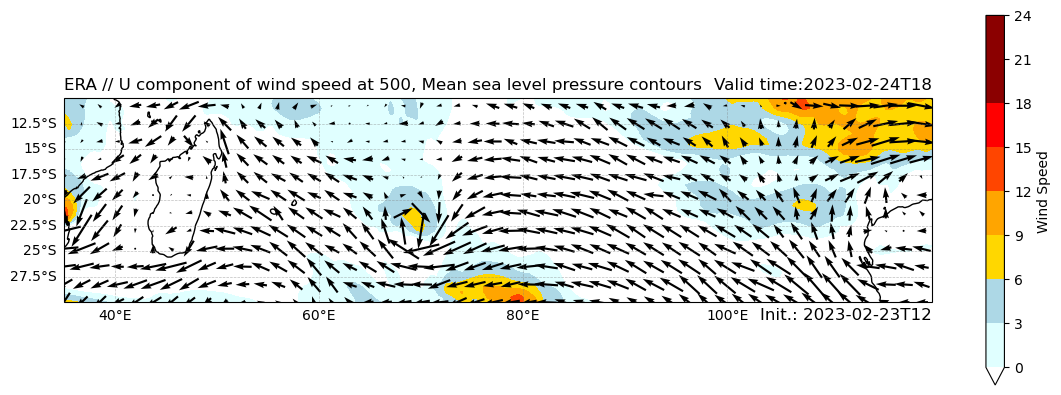

In [153]:
#era_contourfPA_contour_wind(data = era,
#                       contourf_var = era.u,
#                       contourf_var_inwords = "U component of wind speed",
#                       contour_var = era.u,
#                       contour_var_inwords = "Mean sea level pressure",
#                       step_time = "2023-02-24T18:00:00.000000000",
#                       pressure = 500,
#                       contourf_lvl = u_levels,
#                       contour_lvl = u_levels,
#                       legend_colormap = wind_speed_cmap,
#                       legend_label = 'Wind Speed')

In [ ]:
# calculate the distince of both coordinate pairs in km

from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    # Calculate differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Calculate the distance
    distance = R * c
    return distance

# # Example coordinates (latitude and longitude in degrees)
# lat1, lon1 = 52.2296756, 21.0122287  # Warsaw, Poland
# lat2, lon2 = 41.9027835, 12.4963655  # Rome, Italy
# 
# # Calculate distance between the two points
# distance_km = haversine(lat1, lon1, lat2, lon2)
# print("Distance between the two points:", distance_km, "kilometers")



